## Background: ##

Creating NMT models requires a high-quality parallel corpus. However, many translation datasets lack human evaluation, leading to sentence pairs where the source and target sentences are not related. It is crucial to eliminate such pairs to enhance data quality. One effective method involves obtaining sentence embeddings for these pairs and filtering them based on similarity. \

While English has reliable out-of-the-box sentence embedding models, Indian languages face a gap in this regard. Fortunately, Google has introduced [Muril](https://arxiv.org/abs/2103.10730), a BERT-style model trained on Indian languages, which we can use for generating sentence embeddings.

## Context: ##

This post will adopt an investigative format, addressing a problem, identifying its root cause, and proposing a solution.\

Important aspects to bear in mind:

1) Aim: Evaluate the quality of Muril-based sentence embeddings.

2) Dataset: Utilize [Flores](https://arxiv.org/abs/2106.03193), a human-evaluated dataset with high-quality sentence pairs. Focus specifically on English-Hindi pairs.

3) Task: Given an English sentence, determine its correct counterpart in Hindi.

In [ ]:
!pip install datasets
!pip install sentence-transformers

In [2]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
from pathlib import Path
from tqdm.notebook import tqdm,trange
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from sentence_transformers.util import cos_sim

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Downloading the Flores dataset: ##

We download the [Flores](https://huggingface.co/datasets/facebook/flores) dataset from Hugging Face. We choose the devtest split to avoid data contamination. Our focus is on a limited set of 100 sentence pairs to minimize memory usage and computation time.

In [3]:
def get_flores_data(lang,sample_size):
    dataset = load_dataset("facebook/flores", lang_codes[lang])
    lines = dataset['devtest']['sentence'][:sample_size]
    return lines

In [ ]:
sample_size = 100
lang_codes = {'en':'eng_Latn','hi':'hin_Deva'}
eng_sents = get_flores_data('en',sample_size)
hin_sents = get_flores_data('hi',sample_size)

In [5]:
for eng_sent,hin_sent in list(zip(eng_sents[0:2],hin_sents[0:2])):
    print(f'{eng_sent}')
    print(f'{hin_sent}')
    print('\n')

"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
उन्होंने कहा “कि अब हमारे पास 4 महीने उम्र वाले चूहे हैं जिन्हें मधुमेह नहीं है जो मधुमेह के रोगी थे। ”


Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.
डॉ. एहुड उर, नोवा स्कोटिया के हैलिफ़ैक्स में डलहौज़ी विश्वविद्यालय में चिकित्सा के प्रोफ़ेसर और कनाडाई डायबिटीज़ एसोसिएशन के नैदानिक ​​और वैज्ञानिक विभाग के अध्यक्ष ने आगाह किया कि शोध अभी भी अपने शुरुआती दिनों में है.




## Observing MURIL Output: ##

[MURIL](https://huggingface.co/google/muril-large-cased),which uses a BERT architecture, is trained using a self-supervised masked language modeling task on Indian languages.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModelForMaskedLM.from_pretrained("google/muril-base-cased",output_hidden_states=True)
model = model.to(device)

We select a batch of 5 English sentences. Post-tokenization and padding, we obtain an input tensor of size (5, 61).

In [8]:
batch = eng_sents[0:5]
inputs = tokenizer(batch, padding=True,truncation=True,return_tensors="pt")
inputs = inputs.to(device)
print (f"Batch Size is {inputs['input_ids'].shape[0]}")
print (f"Sequence length after padding is {inputs['input_ids'].shape[1]}")

Batch Size is 5
Sequence length after padding is 61


In a BERT-style model, the CLS token is appended at the beginning of all sentences during the preprocessing stage.

In [9]:
print(inputs['input_ids'][:,0])
print(tokenizer.convert_ids_to_tokens([104]))

tensor([104, 104, 104, 104, 104], device='cuda:0')
['[CLS]']


The MURIL model comprises 13 encoder blocks, resulting in 13 hidden state layers.\
Each hidden state layer has a shape of (batch_size, sequence_length, hidden_dim), with the hidden dimension set at 768.

In [10]:
with torch.inference_mode():
    outputs = model(**inputs)
print (f"Number of hidden state layers {len(outputs['hidden_states'])}")
print (f"Shape of each hidden state is {outputs['hidden_states'][0].shape}")

Number of hidden state layers 13
Shape of each hidden state is torch.Size([5, 61, 768])


## Extracting Sentence Embeddings from Hidden States ##

Typicall, the final hidden state of CLS token is used as representation of input sentence for classification tasks. However,  considering the hidden states from the last four layers is found to be more effective. In our approach, we opt for just 2 hidden states to enhance computational efficiency. As we are utilizing 2 layers, the sentence embedding dimension will be 2 * 768 = 1536.

In [11]:
def get_embeddings(outputs,num_layers):
    batch_size = outputs.hidden_states[0].shape[0]
    n_layer_stack = torch.stack(outputs['hidden_states'][-num_layers:],dim=1)
    cls_embeds = n_layer_stack[:,:,0,:].reshape(batch_size,-1)
    return cls_embeds

embeds = get_embeddings(outputs,num_layers = 2)
embeds.shape

torch.Size([5, 1536])

In [12]:
def get_sentence_embeddings(batch,model=model,tokenizer=tokenizer,num_layers=2):
    inputs = tokenizer(batch, padding=True,truncation=True,return_tensors="pt")
    inputs = inputs.to(device)
    with torch.inference_mode():
        outputs = model(**inputs)
        cls_embeds = get_embeddings(outputs,num_layers)
        torch.cuda.empty_cache()
    return cls_embeds

In this step, we compute embeddings for both the set of 100 English and Hindi sentences.

In [13]:
eng_embeds = get_sentence_embeddings(eng_sents)
hin_embeds = get_sentence_embeddings(hin_sents)
del model
torch.cuda.empty_cache()

## Evaluating the embeddings ##

The task is straightforward: given an English sentence, can we use the sentence embeddings to identify the matching Hindi translation from the total set of 100 sentences? To achieve this, we leverage the concept of Cosine Similarity.

The Cosine score between two vectors represents the cosine of the angle between the vectors in n-dimensional space. A higher cosine score indicates closer vectors, while a lower score signifies greater dissimilarity. The score ranges from -1 to 1.

![png](dotproduct.png)

The Sentence Transformers library provides a convenient function called cos_sim. When given embeddings of two sets of sentences, with sizes m and n respectively, this function generates a cosine similarity matrix of size m x n. The matrix contains the corresponding cosine similarity scores for all possible pairs between embeddings1 and embeddings2.

### Retrieval Process and Score Calculation: ###

To identify the target sentence corresponding to a given source sentence, we determine the index for which the cosine similarity score is the highest. The sentences on either side are in order. For the i-th source sentence, if the maximum cosine score aligns with the i-th target sentence, the retrieval is considered successful. Subsequently, we calculate the average retrieval score across these 100 sentence pairs. 

In [ ]:
def get_retrieval_score(src_embeds,tgt_embeds):
    cosine_scores = cos_sim(src_embeds,tgt_embeds)
    cosine_scores_sorted,sorted_indices = torch.sort(cosine_scores, dim=-1, descending=True)
    top_matches = sorted_indices[:,0].cpu().tolist()
    retrieval_status = [i==index for i,index in enumerate(top_matches)]
    retrieval_score = sum(retrieval_status) / len(retrieval_status)
    return retrieval_score,cosine_scores

Retrieval score of 0.57 is low. Now, let's investigate the causes for it.

In [43]:
retrieval_score,cosine_scores = get_retrieval_score(eng_embeds,hin_embeds)
retrieval_score

0.57

## Identifying the cause ##

Before further investigation, let's examine a sample of the cosine similarity matrix. This is intriguing! The cosine similarity for every pair of sentences is close to 1, indicating that all sentences are closely situated in the latent space.

In [16]:
cosine_scores[:5,:5]

tensor([[1.0000, 0.9999, 1.0000, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, 0.9999, 0.9999],
        [1.0000, 0.9999, 1.0000, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, 0.9999, 0.9999]], device='cuda:0')

In [18]:
embedding_size = eng_embeds.shape[-1]
embedding_size

1536

Given the convergence of all cosine scores towards the maximum, there seems to be an issue at the embedding level. To investigate further, let's plot the embeddings for a pair of English-Hindi sentence pairs.

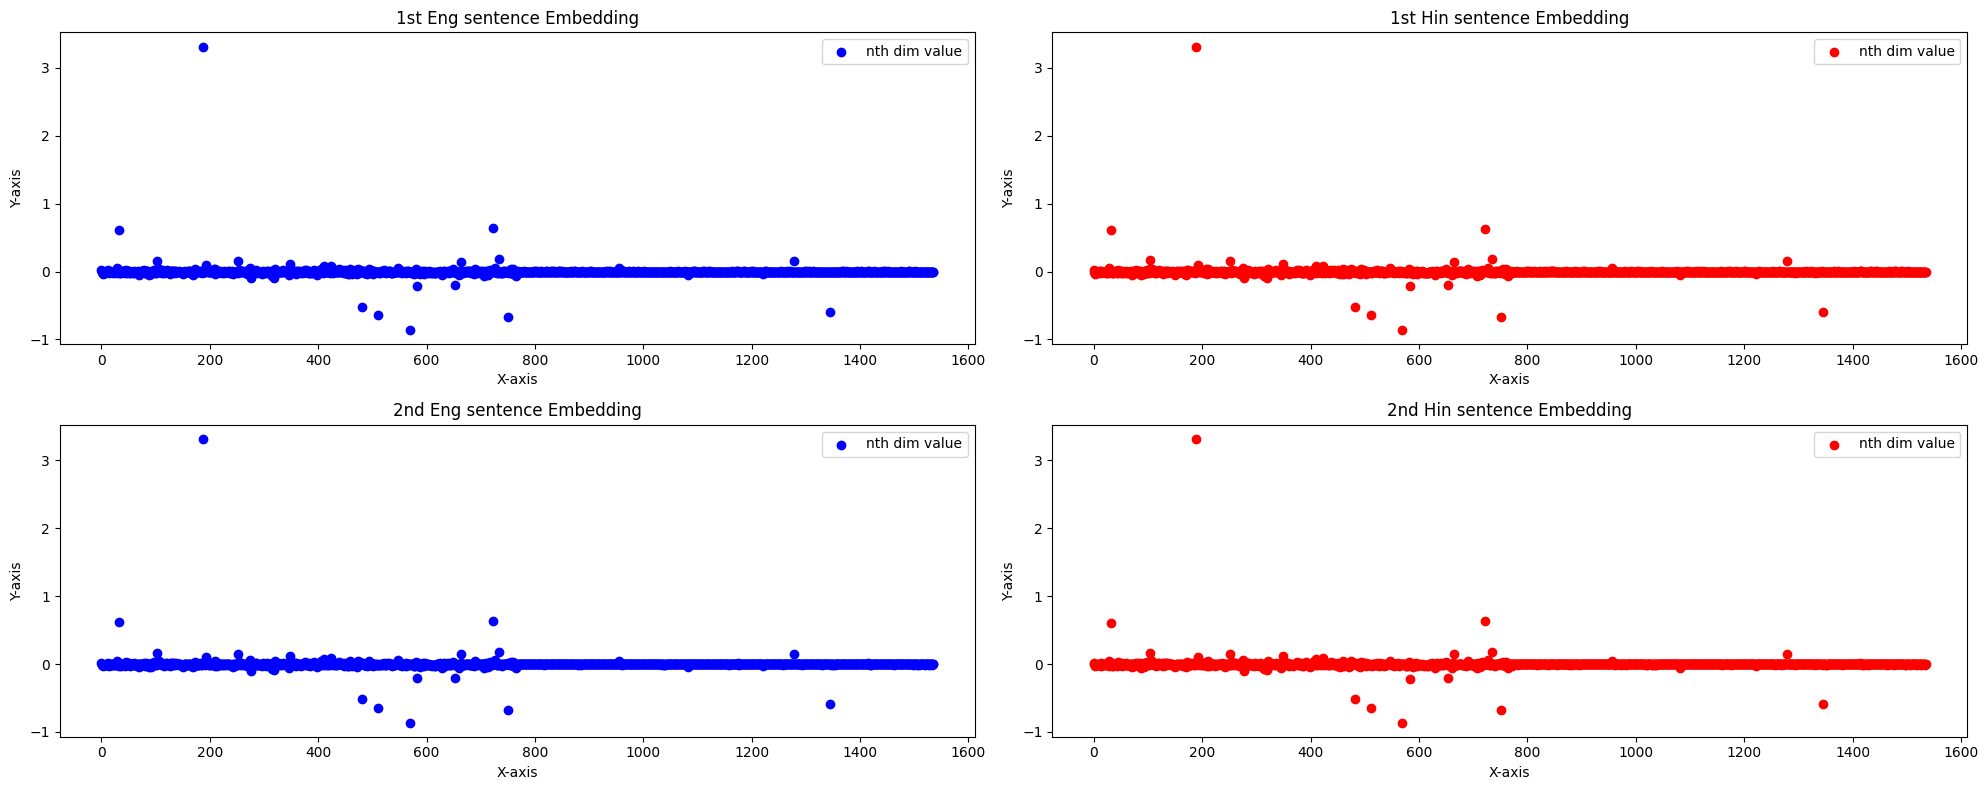

In [22]:
# Create a figure and axis for subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

# Plot the first scatter plot
axs[0,0].scatter(range(embedding_size), eng_embeds[0].cpu().tolist(), color='blue', label='nth dim value')
axs[0,0].set_title('1st Eng sentence Embedding')
axs[0,0].set_xlabel('X-axis')
axs[0,0].set_ylabel('Y-axis')
axs[0,0].legend()

# Plot the second scatter plot
axs[0,1].scatter(range(embedding_size), hin_embeds[0].cpu().tolist(), color='red', label='nth dim value')
axs[0,1].set_title('1st Hin sentence Embedding')
axs[0,1].set_xlabel('X-axis')
axs[0,1].set_ylabel('Y-axis')
axs[0,1].legend()

axs[1,0].scatter(range(embedding_size), eng_embeds[1].cpu().tolist(), color='blue', label='nth dim value')
axs[1,0].set_title('2nd Eng sentence Embedding')
axs[1,0].set_xlabel('X-axis')
axs[1,0].set_ylabel('Y-axis')
axs[1,0].legend()

# Plot the second scatter plot
axs[1,1].scatter(range(embedding_size), hin_embeds[1].cpu().tolist(), color='red', label='nth dim value')
axs[1,1].set_title('2nd Hin sentence Embedding')
axs[1,1].set_xlabel('X-axis')
axs[1,1].set_ylabel('Y-axis')
axs[1,1].legend()



# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

Success! We've identified the issue. While most embedding values are small across all dimensions, there are outliers that differ significantly in magnitude. To confirm, we examine whether these outliers occur at the same dimensions. By sorting the values within an embedding, we observe that these outliers consistently appear at fixed dimensions.

In [23]:
_, sorted_eng_indices = torch.sort(eng_embeds,dim = -1,descending =True)
_, sorted_hin_indices = torch.sort(hin_embeds,dim = -1,descending =True)
sorted_eng_indices[:5,:5],sorted_hin_indices[:5,:5]

(tensor([[188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103]], device='cuda:0'),
 tensor([[188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103],
         [188, 722,  32, 734, 103]], device='cuda:0'))

Given 2 vectors, (a<sub>x</sub>, a<sub>y</sub>, a<sub>z</sub>)  and (b<sub>x</sub>, b<sub>y</sub>, b<sub>z</sub>), the numerator in cosine similarity score is a<sub>x</sub>b<sub>x</sub>+a<sub>y</sub>b<sub>y</sub>+a<sub>z</sub>b<sub>z</sub>.

If one dimension, let's say x, is two orders of magnitude higher than the others, the corresponding product becomes four orders of magnitude larger. Consequently, the contribution to the dot product from the remaining dimensions becomes negligible, making them less impactful in the cosine similarity score.


## Solution:Addressing Dimension Discrepancy for Improved Cosine Similarity ##

The solution is straightforward: we must ensure that all dimensions are on equal footing. This can be achieved through standardization, a process of scaling values to have a mean of 0 and a standard deviation of 1. Specifically, for each dimension, the mean and standard deviation are calculated across the sentences.

Let's proceed with standardizing the English and Hindi embeddings.

In [24]:
eng_mean = eng_embeds.mean(dim=0, keepdim=True)
eng_std = eng_embeds.std(dim=0, keepdim=True)
print(f'Shape of the Mean - {eng_mean.shape}')
print(f'Shape of the Standard Deviation - {eng_std.shape}')
eng_embeds_std = (eng_embeds - eng_mean) / eng_std
eng_embeds_std.shape

Shape of the Mean - torch.Size([1, 1536])
Shape of the Mean - torch.Size([1, 1536])


torch.Size([100, 1536])

In [25]:
hin_mean = hin_embeds.mean(dim=0, keepdim=True)
hin_std = hin_embeds.std(dim=0, keepdim=True)
print(f'Shape of the Mean - {hin_mean.shape}')
print(f'Shape of the Standard Deviation - {hin_std.shape}')
hin_embeds_std = (hin_embeds - hin_mean) / hin_std
hin_embeds_std.shape

Shape of the Mean - torch.Size([1, 1536])
Shape of the Standard Deviation - torch.Size([1, 1536])


torch.Size([100, 1536])

To validate the effectiveness of standardization, we will plot the new standardized embeddings for a pair of English-Hindi sentence pairs.

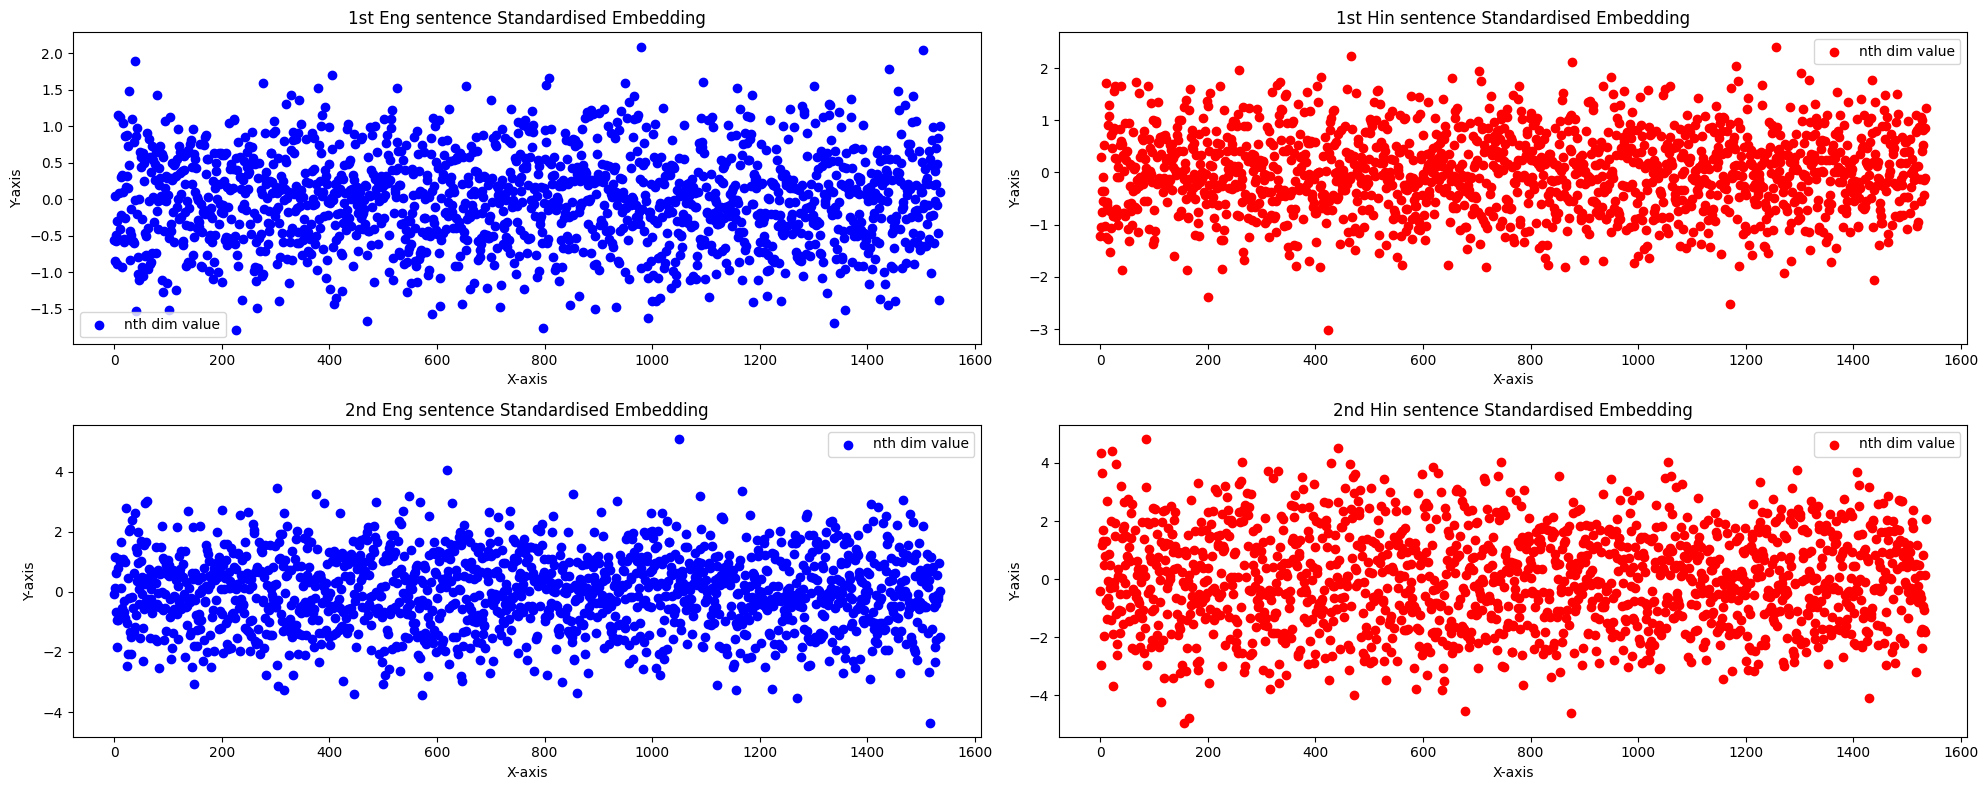

In [26]:
# Create a figure and axis for subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

# Plot the first scatter plot
axs[0,0].scatter(range(embedding_size), eng_embeds_std[0].cpu().tolist(), color='blue', label='nth dim value')
axs[0,0].set_title('1st Eng sentence Standardised Embedding')
axs[0,0].set_xlabel('X-axis')
axs[0,0].set_ylabel('Y-axis')
axs[0,0].legend()

# Plot the second scatter plot
axs[0,1].scatter(range(embedding_size), hin_embeds_std[0].cpu().tolist(), color='red', label='nth dim value')
axs[0,1].set_title('1st Hin sentence Standardised Embedding')
axs[0,1].set_xlabel('X-axis')
axs[0,1].set_ylabel('Y-axis')
axs[0,1].legend()

axs[1,0].scatter(range(embedding_size), eng_embeds_std[1].cpu().tolist(), color='blue', label='nth dim value')
axs[1,0].set_title('2nd Eng sentence Standardised Embedding')
axs[1,0].set_xlabel('X-axis')
axs[1,0].set_ylabel('Y-axis')
axs[1,0].legend()

# Plot the second scatter plot
axs[1,1].scatter(range(embedding_size), hin_embeds_std[1].cpu().tolist(), color='red', label='nth dim value')
axs[1,1].set_title('2nd Hin sentence Standardised Embedding')
axs[1,1].set_xlabel('X-axis')
axs[1,1].set_ylabel('Y-axis')
axs[1,1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We can observe the absence of outliers and better uniformity across dimensions.

Let us calculate the retrieval scores again with these new embeddings. We can see nearly 50% improvement in the retrieval scores. 

In [50]:
retrieval_score_std,cosine_scores_std = get_retrieval_score(eng_embeds_std,hin_embeds_std)
print (f'Retrieval score using raw embeddings - {retrieval_score}')
print (f'Retrieval score using standardised embeddings - {retrieval_score_std}')

Retrieval score using raw embeddings - 0.57
Retrieval score using standardised embeddings - 0.89


Now, let's examine the cosine similarity scores on the standardized embeddings. The results appear more sensible, reflecting the effectiveness of the standardization process

In [44]:
cosine_scores_std[:5,:5]

tensor([[ 0.5752, -0.1172,  0.1556, -0.1349, -0.0472],
        [ 0.0638,  0.5539, -0.1612,  0.0846,  0.0353],
        [ 0.2283, -0.0919,  0.6028, -0.0343, -0.0223],
        [-0.0290,  0.1291, -0.0628,  0.4222,  0.0085],
        [-0.1621,  0.0786, -0.0458,  0.1506,  0.2759]], device='cuda:0')

We will visualize the cosine similarity scores matrix both before and after standardization through a heatmap. Considering that cosine scores range from -1 to 1, the color bars will be adjusted accordingly to provide a clear comparison.

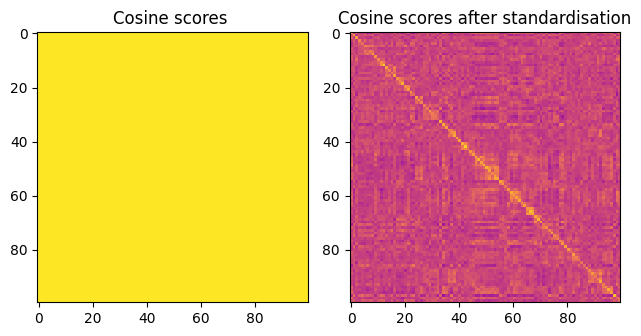

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 1x2 grid of subplots
plt.subplot(1, 2, 1)
plt.imshow(cosine_scores.cpu().numpy(), cmap='viridis', interpolation='nearest',vmin=-1,vmax=1)
plt.title('Cosine scores ')

plt.subplot(1, 2, 2)
plt.imshow(cosine_scores_std.cpu().numpy(), cmap='plasma', interpolation='nearest',vmin=-1,vmax=1)
plt.title('Cosine scores after standardisation')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

Upon comparing the two plots, the left one lacks a discernible pattern. However, in the right plot, a pronounced diagonal becomes apparent. \
This diagonal alignment is a result of the maximum cosine similarity score occurring when there is a correct match. These instances correspond to points of the format (i, i), and these points lie on the diagonal.

The presence of outliers in activations is a common occurrence in Transformer models. Such outliers pose interesting challenges, particularly in the context of the quantization process, which I will explore in a future blog post.